# Задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

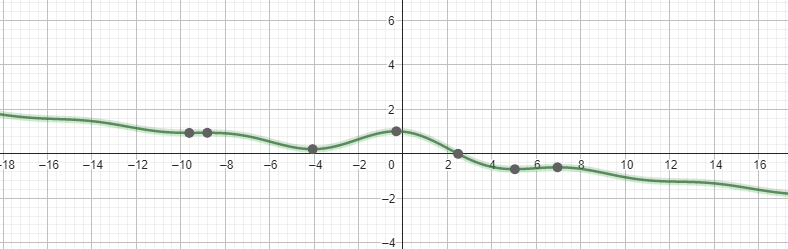

In [1]:
import numpy as np

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, point):        
        validity = self.model(point)
        return validity

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()      
        self.model = nn.Sequential(
            nn.Linear(2, 128),  
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),        
#            nn.Tanh()
        )

    def forward(self, z):
        point = self.model(z)
 
        return point

**Generating data**

In [4]:
data_length = 2048
train_data = torch.zeros((data_length, 2))

train_data[:, 0] = torch.linspace(-4, 5, data_length)

# y = sin(x)/x - x/10
train_data[:, 1] = (torch.sin(train_data[:, 0])/ (train_data[:, 0])) - ((train_data[:, 0])/10)


In [5]:
train_labels = torch.zeros(data_length)
train = [
    (train_data[i], train_labels[i]) for i in range(data_length)]

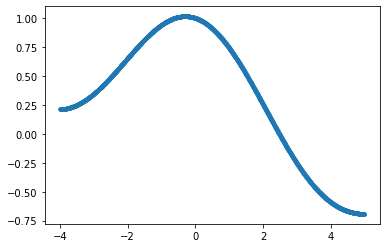

In [6]:

plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [7]:
n_epochs = 100  # количество эпох
lr = 0.001  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

batch_size = 32


In [8]:
generator = Generator()
discriminator = Discriminator()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [9]:
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True)

In [10]:
len(train_loader)

64

In [11]:
for epoch in range(n_epochs):
    for i, (points, labels) in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)

        # Генерация шума
        z = torch.randn((batch_size, 2))
        
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(points)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.randn((batch_size, 2))
        
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

   

**new data generated graph**

In [12]:
new_points = torch.randn(500, 2)
gen_points = generator(new_points)

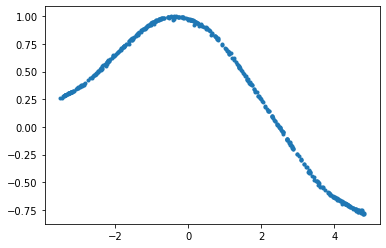

In [13]:
gen_points = gen_points.detach()
plt.plot(gen_points[:, 0], gen_points[:, 1], ".")